# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [119]:
# import libraries here; add more as necessary
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
%%javascript
// Disables cell autoscrolling. Code borrowed from
// https://bit.ly/3xBL7HR

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Specify a max of 100 rows for displayed Dataframes
pd.options.display.max_rows = 100

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
def my_load(filename, func=pd.read_csv, *args, **kwargs):
    udacity_path = '../../data/Term2/capstone/arvato_data'.split('/')
    full_path = os.path.join(*udacity_path, filename)
    
    errors = []
    
    try:
        df = func(full_path, **kwargs)
        return df
    except Exception as e:
        errors.append(e)
    
    try:
        df = func(filename, **kwargs)
        return df
    except Exception as e:
        errors.append(e)
    
    if errors:
        raise Exception(errors)
#     raise Exception('Error when loading the file...\
#     Please check the path is either current directory or ../../data/Term2/capstone/arvato_data ')

In [5]:
# load in the data
azdias = my_load('Udacity_AZDIAS_052018.csv', sep= ';')
customers = my_load('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Mohammed\miniconda3\envs\DSND_Cap_Clone\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


The first thing to notice is the warning about columns 18 and 19 being of mixed types (shown below). We will investigate that later. However, let us start by just looking at the basic structure of the data (azdias)

In [6]:
azdias.iloc[:,17:19].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015
0,NaN,NaN
1,8A,8
2,4C,4
3,2A,2
4,6B,6


In [7]:
azdias.iloc[:,18].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

Looks like the `X` represents missing values

In [8]:
azdias.iloc[:,17].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

Looks like the `XX` represents missing values

In [9]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


Looks like the data is relatively big with a disk space of 2.4+ GB and 366 columns of which 267 are float, 93 are ints, and 6 are either strings or mixed.<br>
The first step is to identify unknown values (nans). For that, the `DIAS Attributes - Values 2017.xlsx` file is needed. Upon a quick skim over that file, it seems that the nans are signaled in the `Meaning` column by either the phrase `unknown` or `no ... known ...`. The most approach to handle this is by filtering the rows by the `known` phrase then extracting corresponding values from the `Value` column 

In [11]:
def get_unknown_meanings():
    df = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    df.ffill(inplace=True)
    df = df[df.Meaning.str.contains('known')]
    df.to_csv('tmp.csv')
    return df
unknowns = get_unknown_meanings()
unknowns.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown


Just to make sure that we don't have irrelevant rows, I will print all different values of Meaning

In [12]:
set(unknowns.Meaning.values)

{'company building w/o known company ',
 'mixed building without actually known company ',
 'mixed building without actually known household ',
 'mixed building without actually known household or comapny ',
 'no transaction known',
 'no transactions known',
 'residental building buildings without actually known household',
 'unknown',
 'unknown / no main age detectable'}

It turns out that the phrases that indicate missing values are only the following:
<ul>
    <li>unknown</li>
    <li>unknown / no main age detectable</li>
    <li>no transaction known</li>
    <li>no transactions known</li>
</ul>

In [13]:
def get_unknown_meanings_updated():
    df = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    df.ffill(inplace=True)
    lst_of_unknowns = ['unknown',
                       'unknown / no main age detectable',
                       'no transaction known',
                       'no transactions known'
                      ]
    df = df[df.Meaning.str.contains('|'.join(lst_of_unknowns))]
    df.to_csv('tmp2.csv')
    return df
unknowns = get_unknown_meanings_updated()
unknowns.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown


Now we need to extract the relevant values that indicate missing values for each column of the dataset

In [14]:
def get_unknown_vals():
    unknowns = get_unknown_meanings_updated()
    unknown_vals = unknowns[['Attribute', 'Value']].set_index('Attribute').astype({'Value':str})
    return unknown_vals

In [15]:
unknown_vals = get_unknown_vals()

It is important to remember that not all the attributes mentioned in the Attribute file contain unknown indicators. So, it is good to list those attributes here as they.<br>
<br>


Now that we are doing with identifying missing values specified in the Attribute file, it is time to add back the columns that were specified in the Attribute file but contained none of the `unknown` catch phrases mentioned above

In [16]:
def get_non_unknown_meanings(unknown_vals):
    df = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    df.ffill(inplace=True)
    
    attributes_of_interest = set(df.Attribute.unique()) - set(unknown_vals.index) 
    return attributes_of_interest

cols_with_no_unknowns = get_non_unknown_meanings(unknown_vals)
cols_with_no_unknowns

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'CAMEO_DEU_2015',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'GEBAEUDETYP_RASTER',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'KBA13_ANZAHL_PKW',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'MIN_GEBAEUDEJAHR',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'PLZ8_BAUMAX'}

In [17]:
len(cols_with_no_unknowns)

25

In [18]:
print(f'Looks like there are {len(set(unknowns.Attribute.values))} \
different attributes that need to be addressed in terms of identifying \
missing values. And, there are {len(cols_with_no_unknowns)} \
columns that don\'t have missing values indicators')

Looks like there are 289 different attributes that need to be addressed in terms of identifying missing values. And, there are 25 columns that don't have missing values indicators


However, upon further inspection, it turns out that there are differences between the columns specified in the Attributes sheet and the columns found in the AZDIAS dataframe. <br>

In [19]:
df = azdias.copy()

In [20]:
def parse_missing_and_unknown(entry):
    def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False
    
    lst = entry.split(',')
    lst = [float(num) if is_number(num) else num for num in lst]
    return lst



In [21]:
print(f'For example, There are {len(set(unknown_vals.index) - set(df.columns))} columns that we can identify nans for \
but are not available in the AZDIAS dataframe')
print(f'On the other hand, there are {len(set(df.columns) - set(unknown_vals.index)  ) - len(cols_with_no_unknowns) - 1} columns which we don\'t have information to identify nans with, since \
they are not mentioned in the Attribute sheet but available in the AZDIAS dataframe' )
print(f'Fortunately, there are {len(set(df.columns) & set(unknown_vals.index)) + len(cols_with_no_unknowns) + 1} columns that overlap and we can identify nans for')

For example, There are 42 columns that we can identify nans for but are not available in the AZDIAS dataframe
On the other hand, there are 93 columns which we don't have information to identify nans with, since they are not mentioned in the Attribute sheet but available in the AZDIAS dataframe
Fortunately, there are 273 columns that overlap and we can identify nans for


In case this is confusing, here is a Venn Diagram to illustrate what we found.

<img src="Venn Diagram.png" alt="Data Types Venn Diagram" >

In [22]:
print(f'We have {len(set(unknown_vals.index) - set(df.columns))} columns that are Type I.\
(irrelevant since we don\'t have data on it)')
print(f'{len(set(df.columns) - set(unknown_vals.index)  ) - len(cols_with_no_unknowns) - 1} columns of Type II.\
(most like are going to be dropped as discussed below)' )
print(f'And, {len(set(df.columns) & set(unknown_vals.index)) + len(cols_with_no_unknowns) + 1} columns that are of Type III.\
(what we are looking for)')

We have 42 columns that are Type I.(irrelevant since we don't have data on it)
93 columns of Type II.(most like are going to be dropped as discussed below)
And, 273 columns that are of Type III.(what we are looking for)


On the good side, the majority of the columns can be processed easily, since they are overlapping between the 2 sheets. However, there is a large number of columns that are remaining. Those remaining columns are going to be addressed individually if there turned out to be a need to include them for further analysis. However, most likely, these columns are going to be dropped, because cleanliness of the data that is produced at this step is of top priority. Another reason is that learning models don't perform well (or not at all) with missing values.  

In [23]:
def clean_data_by_dropping_type_II(df):
    print('Starting Dropping Type II...', end='')
    unknown_vals = get_unknown_vals()
    cols_with_no_unknowns = get_non_unknown_meanings(unknown_vals)
    tmp = set(set(df.columns) - (set(unknown_vals.index) | set(cols_with_no_unknowns)))
    tmp.remove('LNR')
    cols_to_drop = list(tmp)
    df = df.drop(columns=cols_to_drop, errors='ignore')
    print('Completed')
    return df
print(df.shape)
df = clean_data_by_dropping_type_II(df)
print(df.shape)

(891221, 366)
Starting Dropping Type II...Completed
(891221, 273)


In [24]:
print('These are the remaining columns mentioned above (Type I), which will be ignored as there is no data')
set(unknown_vals.index) - set(df.columns) 

These are the remaining columns mentioned above (Type I), which will be ignored as there is no data


{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

As mentioned, there are multiple columns that are found in the Attribute sheet and cannot be found in the AZDIAS data (Type I). However, several of those have a very similar corresponding column names. For example, `D19_BANKEN_GROSS_RZ` is found in the Attributes and not in AZDIAS. However, `D19_BANKEN_GROSS` can be found in AZDIAS. There could be several reasons for this. One reason would be that these are different and unrelated columns. However, it is also possible that this is only a mismatch in the column names based on factors like (data storage database or differently located server). In other words, it could represent a lack of synchronization between the 2 files. Another possibility is that these are different stages of storing the same data, or that they were undergone different processing or preprocessing phases<br>
Let's count how many of these columns are found

In [25]:
def get_columns_with_similar_names():
    lst1 = list(set(unknown_vals.index) - set(df.columns) ) # type I
    lst2 = list(set(df.columns) - set(unknown_vals.index) ) # type II
    
    lst1 = [e[:-3] if e.endswith('_RZ') else e for e in lst1 ] # remove _RZ if col name ends with it
    return list(set(lst1) & set(lst2))
print(f'There are {len(get_columns_with_similar_names())} such columns')
get_columns_with_similar_names()

There are 0 such columns


[]

These columns could be used in our analysis. However, it is really hard to prove that the columns found in the Attribute file correspond to the ones that are similar from AZDIAS. Therefore, they are going to be ignored for now. However, if a need arises to use them, then they can be potentially used with careful pre-processing/inspection.<br>
<br>
For now, we are sticking with the column names that are overlapping between the 2 files (mentioned in Attribute and AZDIAS)<br>
The next step is to replace the values specified by the Value column to nans.

In [26]:
# replace values specified in Attribute with NaNs
def clean_data_replace_missing_values_with_nans(df):
    for col in list(set(unknown_vals.index) & set(df.columns)):
        lst_of_values_to_be_converted_to_nans = parse_missing_and_unknown(unknown_vals['Value'][col])
        df.loc[df[col].isin(lst_of_values_to_be_converted_to_nans), col] = np.nan
    return df
df = clean_data_replace_missing_values_with_nans(df)    

In [27]:
azdias.shape,df.shape

((891221, 366), (891221, 273))

In [28]:
azdias.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [29]:
df.AGER_TYP.value_counts()

2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64

Looks like missing values are detected and replaced properly. However, there is more cleaning to do. Some columns appear to be categorical, while others appear to be mixed. Careful handling needs to be used to address each of those.<br>
However, before we start with that, one thing to do is to investigate the distribution of missing values in the dataset.<br>
As can be seen below, the number of rows with no missing values is 0 (even after filtering out the columns that were not cleaned in the previous step)

In [30]:
# df = df[list(set(unknown_vals.index) & set(df.columns))]

In [31]:
df[~df.isnull().any(axis=1)].head()

,LNR,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


This is just too few. I am suspecting that there is at least one column that contains lots of missing data. So, let's check the percentage of nans in each column 

In [32]:
num_of_nans = df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100
num_of_nans

TITEL_KZ                       99.757636
D19_TELKO_ONLINE_DATUM         99.079577
D19_BANKEN_OFFLINE_DATUM       97.791120
D19_TELKO_ANZ_12               96.271295
D19_BANKEN_ANZ_12              93.325225
D19_TELKO_ANZ_24               92.705176
D19_VERSI_ANZ_12               92.153237
D19_TELKO_OFFLINE_DATUM        91.909190
D19_BANKEN_ANZ_24              89.102479
D19_VERSI_ANZ_24               87.187914
D19_BANKEN_ONLINE_DATUM        81.571462
D19_BANKEN_DATUM               76.112547
AGER_TYP                       76.019640
D19_TELKO_DATUM                74.706274
D19_VERSAND_ANZ_12             71.584040
D19_VERSAND_OFFLINE_DATUM      71.164504
D19_GESAMT_ANZ_12              65.617507
D19_VERSAND_ANZ_24             63.263545
D19_GESAMT_OFFLINE_DATUM       62.673344
D19_GESAMT_ANZ_24              56.697834
D19_VERSAND_ONLINE_DATUM       55.481637
KBA05_BAUMAX                   53.468668
D19_GESAMT_ONLINE_DATUM        50.604171
D19_VERSAND_DATUM              49.133268
D19_GESAMT_DATUM

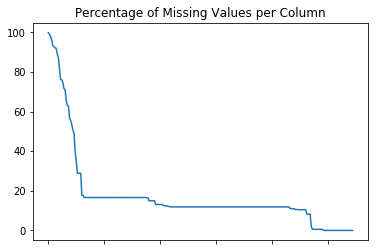

In [33]:
num_of_nans.plot();
plt.title('Percentage of Missing Values per Column');

In [34]:
import pickle
def get_remaining_after_dropping_columns(df, num_of_nans):
    times = []
    
    tmp = df.copy()
    initial_count_of_nans = tmp.count().sum()
    counts_of_non_nans = [100.]
    num_of_rows_without_nans = [0]
    t0 = time.time()
    times.append(t0)
    print(f'Starting ... {time.time() - t0:0.2f}sec')
    
    for i, col in enumerate(num_of_nans.index):
        print(f'{i:03d}\t{col}', end='\t')
        tmp = tmp.drop(columns=[col])
        try:
            counts_of_non_nans.append(tmp.count().sum()*100/initial_count_of_nans)
            num_of_rows_without_nans.append(len(tmp[~tmp.isnull().any(axis=1)].index))
        except Exception as e:
            print(str(e))
        new_time = time.time()-t0
        times.append(new_time)
        print(f'{new_time:0.2f}sec') 
    
    stored = {'times': times,
              'result': (counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans)
             }
    pickle.dump(stored, open(os.path.join('pickles', 'remaining_after_drop.pickle'), 'wb'))
    
    return counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans

try:
    stored = pickle.load(open(os.path.join('pickles', 'remaining_after_drop.pickle'),'rb'))
    times = stored['times']
    counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans = stored['result']
    
    print('Starting ... 0.00sec')
    for i, col in enumerate(num_of_nans.index):
        print(f'{i:03d}\t{col}\t{times[i+1]:0.2f}sec')
except (OSError, IOError) as e:
    counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans = get_remaining_after_dropping_columns(df, num_of_nans)

Starting ... 0.00sec
000	TITEL_KZ	5.46sec
001	D19_TELKO_ONLINE_DATUM	10.98sec
002	D19_BANKEN_OFFLINE_DATUM	16.38sec
003	D19_TELKO_ANZ_12	21.80sec
004	D19_BANKEN_ANZ_12	27.18sec
005	D19_TELKO_ANZ_24	32.52sec
006	D19_VERSI_ANZ_12	37.84sec
007	D19_TELKO_OFFLINE_DATUM	43.13sec
008	D19_BANKEN_ANZ_24	48.41sec
009	D19_VERSI_ANZ_24	53.71sec
010	D19_BANKEN_ONLINE_DATUM	58.96sec
011	D19_BANKEN_DATUM	64.21sec
012	AGER_TYP	69.49sec
013	D19_TELKO_DATUM	74.92sec
014	D19_VERSAND_ANZ_12	80.19sec
015	D19_VERSAND_OFFLINE_DATUM	85.51sec
016	D19_GESAMT_ANZ_12	90.82sec
017	D19_VERSAND_ANZ_24	96.10sec
018	D19_GESAMT_OFFLINE_DATUM	101.29sec
019	D19_GESAMT_ANZ_24	106.50sec
020	D19_VERSAND_ONLINE_DATUM	111.75sec
021	KBA05_BAUMAX	117.03sec
022	D19_GESAMT_ONLINE_DATUM	122.26sec
023	D19_VERSAND_DATUM	127.47sec
024	D19_GESAMT_DATUM	132.68sec
025	ALTER_HH	137.97sec
026	D19_GESAMT_ONLINE_QUOTE_12	143.27sec
027	D19_KONSUMTYP	148.43sec
028	D19_BANKEN_ONLINE_QUOTE_12	153.65sec
029	D19_VERSAND_ONLINE_QUOTE_12	158.92sec


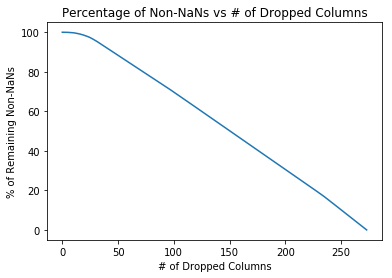

In [35]:
plt.plot(range(len(counts_of_non_nans)), counts_of_non_nans);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

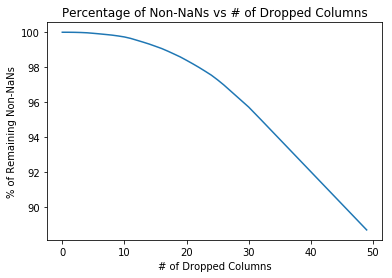

In [36]:
plt.plot(range(len(counts_of_non_nans[:50])), counts_of_non_nans[:50]);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

Looks like the drop of starts around 25 columns. That means that even after dropping the top 25 columns with the most amount of missing values, we get to  used about 96% of the data found in the data set

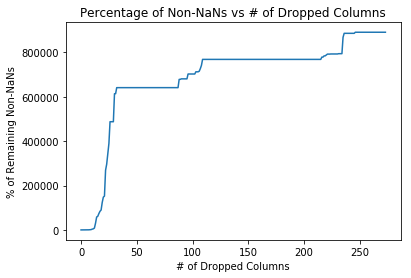

In [37]:
plt.plot(range(len(num_of_rows_without_nans)), num_of_rows_without_nans);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

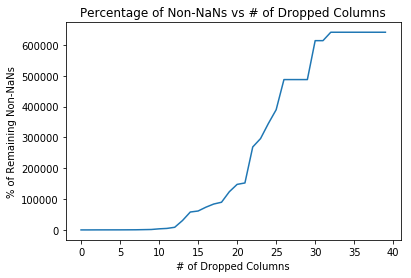

In [38]:
plt.plot(range(len(num_of_rows_without_nans[:40])), num_of_rows_without_nans[:40]);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

A similar conclusion can be drawn from counting the number of remaining rows with no missing values after dropping the columns. Looks like we need to zoom in to decide on the exact number

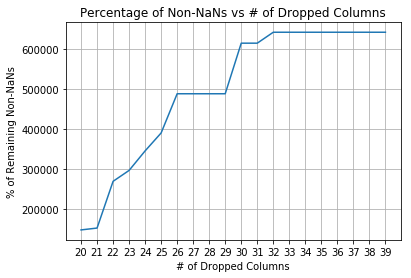

In [39]:
plt.plot(range(20, len(num_of_rows_without_nans[:40])), num_of_rows_without_nans[20:40]);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');
plt.xticks(np.arange(20,40));
plt.grid()

It turns out that our magic number is 30. (drop the top most 30 columns with nans)<br>
These are the columns to be dropped

In [40]:
num_of_nans.index.values.tolist()[:30]

['TITEL_KZ',
 'D19_TELKO_ONLINE_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_TELKO_ANZ_12',
 'D19_BANKEN_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ANZ_24',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_DATUM',
 'AGER_TYP',
 'D19_TELKO_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ONLINE_DATUM',
 'KBA05_BAUMAX',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_GESAMT_DATUM',
 'ALTER_HH',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12']

In [127]:
def clean_data_by_dropping_cols_with_many_nans(df):
    print('Starting Dropping Columns with Many NaNs...', end='')
    df = df.drop(columns=num_of_nans.index.values.tolist()[:30], errors='ignore')
    df = df.drop(columns=['LNR'] )
    print('Completed')
    return df
#df = clean_data_by_dropping_cols_with_many_nans(df)

Now that we have identified missing values for the numerical columns, let's take a look at columns of type string

In [42]:
df.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ
0,NaN,NaN,NaN
1,8A,8,W
2,4C,4,W
3,2A,2,W
4,6B,6,W


In [43]:
tmp = df.select_dtypes(include="object").columns.values
print(f'Looks like there are {len(tmp)} such columns')
print(tmp)

Looks like there are 3 such columns
['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'OST_WEST_KZ']


Let us consider the values for the first of those columns

In [44]:
df.CAMEO_DEU_2015.value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

Looks like the value `XX` is invalid as it is not mentioned in the Attribute file. Let us convert that into NaN.

In [45]:
df.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

Looks like the value `X` is invalid as it is not mentioned in the Attribute file. Let us convert that into NaN. Also, the floats and integers should be combined (e.g. 1 & 1.0).

In [46]:
df.OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

Nothing strange here! Values need to be converted to 0s and 1s though

In [47]:
def clean_data_by_fixing_string_cols(df):
    print('Starting fixing string columns...', end='')
    df.loc[df.CAMEO_DEU_2015 == 'XX','CAMEO_DEU_2015'] = np.nan
    #TODO dummy variable for CAMEO_DEU_2015
    
    df.loc[df.CAMEO_DEUG_2015 == 'X','CAMEO_DEUG_2015'] = np.nan
    df.CAMEO_DEUG_2015 = df.CAMEO_DEUG_2015.astype(np.float)
    
    naming_mapping = {'OST_WEST_KZ':{'O':0, 'W':1}}
    df.replace(naming_mapping, inplace=True)
    
    print('Completed')
    
    return df
df = clean_data_by_fixing_string_cols(df)

Starting fixing string columns...Completed


columns are fixed now

In [48]:
df.CAMEO_DEU_2015.value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

Looks good! <br>
Moving on to the other columns

In [49]:
df.CAMEO_DEUG_2015.value_counts()

8.0    134441
9.0    108177
6.0    105874
4.0    103912
3.0     86779
2.0     83231
7.0     77933
5.0     55310
1.0     36212
Name: CAMEO_DEUG_2015, dtype: int64

In [50]:
df.OST_WEST_KZ.value_counts()

1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64

All good!

In [51]:
# This is done to manually check the values of the columns and that there are nothing that looks odd
with open('type-values.txt', 'w') as f:
    for col in df.columns:
        f.write(f'#########\n{col}\n')
        f.write(f'{df[col].value_counts()}\n\n')
    

All that remains is to clean/pre-process the columns based on their types. There are 4 basic types:
<ul>
    <li>Numeric: such as integers, floats, ranges, etc.</li>
    <li>Ordinal data: Although, they could be treated as categorical or at least with some further processing, for the sake of simplicity, we are going to use them as is. It is not an unusual practice to treat ordinals as numeric values</li>
    <li>categorical: this type is similar to ordinal, but doesn't have the property of following some kind of a trend/sequence. Those are going to be treated individually and would be converted into on-hot-encoded format using dummies</li>
    <li>mixed: These contain multiple dimensions combined in one. This is, also, going to be treated individually and would be separtated into multiple columns accordingly.</li>
</ul>
That being said, the categorical and mixed columns are going to be very time consuming to process. So, the following analysis would try to do as many of them as possible within the allowed timeframe (without going overboard).

The first step is to determine, for each column, which type it belongs too. This will be done manually by reading the Attribute file. The main task is to determine the mixed type as well as the categorical type. The rest will be dealt with as numeric/ordinal, which we are going to leave untouched as mentioned above.

In [52]:
def create_attribute_summary(df):
    tmp = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    tmp.ffill(inplace=True)
    
    lst_of_cols = df.columns.values.tolist()
    
    tmp = tmp[tmp.Attribute.isin(lst_of_cols)]
    tmp = tmp.set_index(['Attribute', 'Description'])
    tmp.to_excel('attribute_summary.xls', merge_cells=True)

create_attribute_summary(df)

In [53]:
def get_attribute_types():
    tmp = my_load('attribute_type_summary.xls', func=pd.read_excel)
    tmp = tmp[~tmp.Attribute.isnull()]
    return tmp

attribute_types = get_attribute_types()
attribute_types.groupby('Type').size()

Type
Categorical     22
Mixed            3
Numeric          7
Ordinal        207
dtype: int64

Looks like we have 22 categorical columns as well as 3 mixed ones. The rest are ok as is (Numeric & Ordinal).<br>
Let us start with the Mixed columns

In [54]:
attribute_types[attribute_types.Type == 'Mixed']

,Attribute,Type
1304,LP_LEBENSPHASE_FEIN,Mixed
1344,LP_LEBENSPHASE_GROB,Mixed
1444,PRAEGENDE_JUGENDJAHRE,Mixed


In [55]:
# LP_LEBENSPHASE_FEIN is split into 2 dimensions

def map_to_LP_LEBENSPHASE_FEIN_age(row):
    '''
    maps column according to age, where:
    young = 0
    middle = 1
    higher = 2
    retirement = 3
    advanced = 4
    else = 5
    ambiguous terms are set to middle
    '''
    value = row['LP_LEBENSPHASE_FEIN']
    
    if value in [1, 3, 14, 18, 29, 30, 33, 34, 35]:
        return 0
    elif value in [2, 4, 9, 10, 17, 21, 22, 23, 24, 25, 26, 27, 28, 39]:
        return 1
    elif value in [13, 15, 16, 19, 20, 31, 32, 36]:
        return 2
    elif value in [6, 8, 12, 38, 40]:
        return 3
    elif value in [5, 7, 11, 37]:
        return 4
    else:
        return 5

    
def map_to_LP_LEBENSPHASE_FEIN_income(row):
    '''maps column according to income, where:
    low = 0
    average = 1
    wealthy = 2
    top = 3
    else = 4
    ambiguous terms are set to average
    '''
    value = row['LP_LEBENSPHASE_FEIN']
    if value in [1, 2, 5, 6, 15, 21, 24, 29, 31]:
        return 0
    elif value in [3, 4, 7, 8, 9, 11, 12, 14, 16, 17, 19, 22, 25, 26, 27, 30, 32, 33, 34, 36, 37, 38]:
        return 1
    elif value in [23]:
        return 2
    elif value in [10, 18]:
        return 3
    elif value in [13, 20, 28, 35, 39, 40]:
        return 4
    else:
        return 5
    


The LP_LEBENSPHASE_GROB is similar to LP_LEBENSPHASE_FEIN, since it is referring to the same data but with a coarser scale. The similarity observation comes from the documentation as well as the calculation below

In [56]:
df.LP_LEBENSPHASE_FEIN.corr(df.LP_LEBENSPHASE_GROB)

0.9899607961397078

In [57]:
def map_to_generation(row):
    value = row['PRAEGENDE_JUGENDJAHRE']
    if value == 1 or value == 2:
        return 40
    elif value == 3 or value == 4:
        return 50
    elif value == 5 or value == 6 or value == 7:
        return 60
    elif value == 8 or value == 9:
        return 70
    elif 10 <= value <= 13:
        return 80
    elif value >= 14:
        return 90
    else:
        return value
    
    
def map_to_movement(row):
    value = row['PRAEGENDE_JUGENDJAHRE']
    if value in [1, 3, 5, 8, 10, 12, 14]:
        return 0
    elif value in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 1
    else:
        return value

In [58]:
def clean_data_process_mixed_cols(df):
    print('Starting processing mixed columns...', end='')
    df['LP_LEBENSPHASE_FEIN_age'] = df.apply(lambda row: map_to_LP_LEBENSPHASE_FEIN_age(row), axis=1)
    df['LP_LEBENSPHASE_FEIN_income'] = df.apply(lambda row: map_to_LP_LEBENSPHASE_FEIN_income(row), axis=1)
    
    df['PRAEGENDE_JUGENDJAHRE_GENERATION'] = df.apply(lambda row: map_to_generation(row), axis=1)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df.apply(lambda row: map_to_movement(row), axis=1)
    
    df.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE'], inplace=True, errors='ignore')
    print('Completed')
    return df

df = clean_data_process_mixed_cols(df)

Starting processing mixed columns...Completed


In [59]:
categorical_cols = attribute_types[attribute_types.Type == 'Categorical'].Attribute.values.tolist()
df[categorical_cols].nunique()

ANREDE_KZ              2
CAMEO_DEUG_2015        9
CAMEO_DEU_2015        44
CJT_GESAMTTYP          6
FINANZTYP              6
GEBAEUDETYP            7
GEBAEUDETYP_RASTER     5
HEALTH_TYP             3
KBA05_HERSTTEMP        5
KBA05_MAXHERST         5
KBA05_MODTEMP          6
LP_FAMILIE_FEIN       12
LP_STATUS_FEIN        10
LP_STATUS_GROB         5
NATIONALITAET_KZ       3
OST_WEST_KZ            2
REGIOTYP               7
RETOURTYP_BK_S         5
SHOPPER_TYP            4
VERS_TYP               2
WOHNLAGE               8
ZABEOTYP               6
dtype: int64

In [60]:
def clean_data_process_categorical_cols(df):
    print('Starting processing categorical columns...', end='')
    attribute_types = get_attribute_types()
    categorical_cols = attribute_types[attribute_types.Type == 'Categorical'].Attribute.values.tolist()
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print('Completed')
    return df
    
df = clean_data_process_categorical_cols(df)

Starting processing categorical columns...Completed


In [61]:
def clean_data_drop_rows_with_nans(df):
    print('Starting Dropping rows with NaNs...', end='')
    df = df[~df.isnull().any(axis=1)]
    print('Completed')
    return df

df = clean_data_drop_rows_with_nans(df)

Starting Dropping rows with NaNs...Completed


In [154]:
def clean_data_convert_types_to_float(df):
    print('Starting conversion to floats...', end='')
    for col in df.columns:
#         sys.stdout.write('\r'+col)
#         sys.stdout.write("\033[F")
#         sys.stdout.write("\033[K")
        print('\r', col, end=' '*50)
        df.loc[:,col] = df.loc[:,col].astype(np.float)
#     df.loc[:,col] = df.astype(np.float)
    print('\nConversion to floats Completed')
    return df

df = clean_data_convert_types_to_float(df)

 ZABEOTYP_6.0                                                                      
Conversion to floats Completed


In [151]:
print('Starting...')
for col in azdias:
#     sys.stdout.write('\033[K')
    print('\r', col, end=' '*100)

Starting...
 ALTERSKATEGORIE_GROB                                                                                                    

In [155]:
def clean_data(_df, check_for_customers=False):
    def check_customer():
        if check_for_customers:
            print(f'Customer Group is available = ', 'LNR' in _df.columns)
    
    check_customer()
    _df = _df.copy()
    check_customer()
    _df = clean_data_by_dropping_type_II(_df)
    check_customer()
    _df = clean_data_replace_missing_values_with_nans(_df)
    check_customer()
    _df = clean_data_by_dropping_cols_with_many_nans(_df)
    check_customer()
    _df = clean_data_by_fixing_string_cols(_df)
    check_customer()
    _df = clean_data_process_mixed_cols(_df)
    check_customer()
    _df = clean_data_process_categorical_cols(_df)
    check_customer()
    _df = clean_data_drop_rows_with_nans(_df)
    check_customer()
    _df = clean_data_convert_types_to_float(_df)
    check_customer()
    return _df


In [156]:
df = clean_data(azdias, check_for_customers=True)
df.shape

Customer Group is available =  True
Customer Group is available =  True
Starting Dropping Type II...Completed
Customer Group is available =  True
Customer Group is available =  True
Starting Dropping Columns with Many NaNs...Completed
Customer Group is available =  False
Starting fixing string columns...Completed
Customer Group is available =  False
Starting processing mixed columns...Completed
Customer Group is available =  False
Starting processing categorical columns...Completed
Customer Group is available =  False
Starting Dropping rows with NaNs...Completed
Customer Group is available =  False
 ZABEOTYP_6.0                                                                      
Conversion to floats Completed
Customer Group is available =  False


(632248, 361)

In [157]:
df.isnull().sum().sum()

0

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632248 entries, 1 to 891220
Columns: 361 entries, ANZ_HAUSHALTE_AKTIV to ZABEOTYP_6.0
dtypes: float64(361)
memory usage: 1.7 GB


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Feature Transformation
#### a) Applying Feature Scaling
In order to do the segmentation (clustering), we need to do some feature transformation first. That will be followed by a dimensionality reduction process. Then, the data will be ready for clustering. To be specific, the feature transformation has already started when we dropped the missing data points. Alternatively, we could have used and Imputer the fill in the missing data points. Scaling is done in this phase to make learning easier. That simply means to scale all columns to have a mean of 0 and a standard deviation of 1. As for the dimensionality reduction phase, the Principal Component Analysis is going to be used.

In [98]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data = pd.DataFrame(scaled_data, columns=df.columns)
scaled_data.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
0,0.183613,-0.128712,0.165244,-0.06082,0.867652,-0.599243,1.535474,1.344910,-1.516591,1.576928,...,-0.699244,2.174951,-0.312897,-0.519350,-0.088822,-0.18058,-0.74925,-0.606473,2.964972,-0.308877
1,0.117177,-0.128712,-0.721710,-0.06082,-0.954494,-0.010687,-0.532764,1.344910,-1.516591,0.897840,...,-0.699244,-0.459780,-0.312897,-0.519350,-0.088822,-0.18058,-0.74925,-0.606473,2.964972,-0.308877
2,-0.347879,-0.128712,1.939152,-0.06082,-0.954494,0.577870,-1.222176,-0.852306,0.685677,0.218752,...,1.430116,-0.459780,-0.312897,-0.519350,-0.088822,-0.18058,-0.74925,1.648878,-0.337271,-0.308877
3,-0.215006,-0.128712,-0.721710,-0.06082,0.867652,-1.187800,-0.532764,1.344910,-0.048412,-1.139423,...,-0.699244,-0.459780,-0.312897,1.925483,-0.088822,-0.18058,-0.74925,1.648878,-0.337271,-0.308877
4,-0.281443,-0.128712,-0.721710,-0.06082,0.867652,-0.010687,1.535474,-0.119901,-1.516591,1.576928,...,-0.699244,-0.459780,3.195942,-0.519350,-0.088822,-0.18058,-0.74925,1.648878,-0.337271,-0.308877


#### b) Performing Dimensionality Reduction
Now, it is time to compute the PCA. In order to determine the number of components to consider, we will used spree plots. These plots are going to present how much variance of the data (information) versus the number of components. Our goal is to find a good balance where we are capturing as much variance as possible with as few components as possible.

In [67]:
# These functions are based on functions submitted on old Data Scientist Nanodegree project
def do_pca(n_components, data):
    '''
    Performs PCA on data to produce n_components, and returns results.

    Arguments: n_components - int - the number of principal components
                to create
           data - the data to be transformed

    Returns: pca - the pca object (after fitting the data)
            X_pca - the transformed data with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def fit_random_forest_classifier(X, y):
    '''
    INPUT: X - input data (features)
           y - labels to be fit
    OUTPUT: void - prints the confusion matrix and accuracy
    '''
    #First let's create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.33,
                                                        random_state=42)

    #We could grid search and tune, but let's just fit a simple 
    #model to see how it does instantiate
    clf = RandomForestClassifier(n_estimators=100, max_depth=None)

    #fit
    clf.fit(X_train, y_train)

    #predict
    y_preds = clf.predict(X_test)

    #score
    print(confusion_matrix(y_test, y_preds))
    acc = accuracy_score(y_test, y_preds)
    print(acc)
    return acc

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    Arguments: pca - the result of the do_pca function (X_pca)
            
    Returns: void - creates scree plot
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), 
                    (ind[i]+0.2, vals[i]),
                    va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

def plot_component(pca, comp):
    '''
    Plots an image associated with each component to understand how 
    the weighting of the components 
    Arguments: 
          pca - pca object created from do_pca function
          comp - int - the component you want to see starting at 0
    Returns: void - plots the image
    '''
    if comp <= len(pca.components_):
        #reshape images
        mat_data = np.asmatrix(pca.components_[comp]).reshape(28,28)  
        plt.imshow(mat_data); #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis   
    else:
        print('That is not the right input, please read \
        the docstring before continuing.')

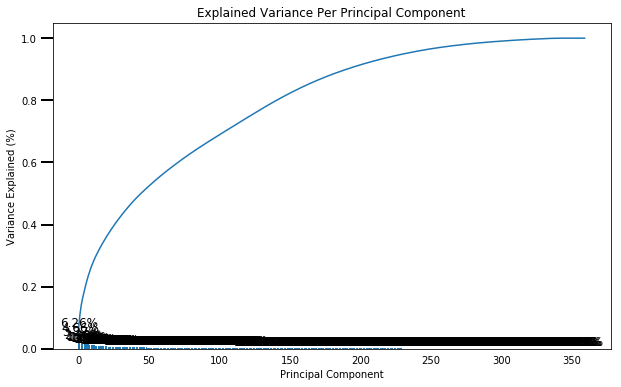

In [68]:
pca, X_pca = do_pca(360, scaled_data)
scree_plot(pca)

It looks from the spree plot above that around 250 components can capture over 90% of the variance of the data. 

In [69]:
pca, X_pca = do_pca(250, scaled_data)

#### Interpreting Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The absolute value of the component represents its weight. While the sign corresponds to its trend (positive components increase together and decrease together. Same goes for negative components.

In order to investigate features, they are goint to be sorted by their weights and the associated feature names are going to be displayed. The first 3 components are going to be investigated below

In [70]:
weights = pd.DataFrame(pca.components_[:3].T,
                       index=df.columns,
                       columns=range(3))

In [71]:
def get_largest_factors(s,head_len=5):
    return s[s.abs().sort_values(ascending=False).index].head(head_len)

In [72]:
get_largest_factors(weights[0])

HH_EINKOMMEN_SCORE    0.150516
MOBI_REGIO           -0.148320
PLZ8_ANTG1           -0.144648
KBA05_ANTG1          -0.143391
PLZ8_ANTG3            0.138229
Name: 0, dtype: float64

the first component represents the following:
* HH_EINKOMMEN_SCORE (estimated household net income) high number means low income
* MOBI_REGIO (moving patterns) high number means low mobility
* KBA05_ANTG1 (number of 1-2 family houses in the cell) 
* PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region) 
* PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)<br>

In other words, this component is related to movement patterns and number of families per home in certain regions. (some sort of population density distribution)

In [73]:
get_largest_factors(weights[1])

KBA13_HERST_BMW_BENZ           0.167739
EWDICHTE                       0.158233
KBA13_ALTERHALTER_60          -0.149194
ORTSGR_KLS9                    0.148203
KBA13_SEG_OBEREMITTELKLASSE    0.147555
Name: 1, dtype: float64

The second component is:

* KBA13_HERST_BMW_BENZ (share of BMW & Mercedes Benz within the PLZ8) 
* EWDICHTE (density of inhabitants per square kilometer) 
* KBA13_ALTERHALTER_60 (share of car owners between 46 and 60 within the PLZ8)
* ORTSGR_KLS9 (size of the community)
* KBA13_SEG_OBEREMITTELKLASSE (share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)<br>

In summary, this component is somehow related to density of inhabitants in PLZ8 and the share of BMW owners.

In [74]:
get_largest_factors(weights[2])

PRAEGENDE_JUGENDJAHRE_GENERATION   -0.235050
FINANZ_SPARER                      -0.233298
ALTERSKATEGORIE_GROB                0.217044
SEMIO_PFLICHT                      -0.215137
SEMIO_REL                          -0.214990
Name: 2, dtype: float64

The third component is:

* PRAEGENDE_JUGENDJAHRE_GENERATION (generation) 
* ALTERSKATEGORIE_GROB (Estimated age based on given name analysis) 
* FINANZ_SPARER (money saver financial typology)
* SEMIO_PFLICHT (affinity indicating in what way the person is dutyfull traditional minded) high number corresponds to low affinity
* SEMIO_REL (affinity indicating in what way the person is religious) high number corresponds to low affinity<br>

In summary, this component is somehow related to people's age, financial saving typology, and their personal affinities (religion, traditinoalism, etc.).

### Clustering

#### a) Applying Clustering to General Population

Now, it's finally the time to see how the data clusters in the principal components space. We will apply k-means clustering (KMeans class) to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep. The k-means clustering is going to be performed on several values of k (between 10 and 30), and the best suited one is going to be chosen. As will be shown, that the average distance of clusters is going to decrease as we increase k. However, the overall value of clustering is going to decreas as we increase k. Therefore, a balance needs to be observed between these 2 metrics.

In [75]:
X_pca_df = pd.DataFrame(X_pca)
sample = X_pca_df.sample(frac=0.1,random_state=0)
sample = sample.values
print(X_pca.shape)
print(sample.shape)

(632248, 250)
(63225, 250)


In [76]:
centers_sample = range(2,51)

In [81]:
try:
    stored = pickle.load(open('kmeans-50.pickle', 'rb'))
    scores_sample = stored['scores_sample']
    times_sample = stored['times_sample']
    centers_sample = stored['centers_sample']
    for k,t in zip(centers_sample, times_sample):
        print(k, t)
except (OSError, IOError) as e:
    
    scores_sample = []
    times_sample = []
    centers_sample = range(2,51)
    for k in centers_sample:
        start = time.time()
        kmeans = KMeans(n_clusters=k, random_state=0).fit(sample)
        scores_sample.append(abs(kmeans.score(sample)))
        timing_sample = time.time() - start
        print(k,timing_sample)
        times_sample.append(timing_sample)
    stored = {'scores_sample':scores_sample,
              'times_sample':times_sample,
              'centers_sample':centers_sample
             }
    pickle.dump(stored, open('kmeans-50.pickle', 'wb'))

2 6.7132179737091064
3 13.774016618728638
4 20.05963110923767
5 20.22841191291809
6 23.375705242156982
7 30.53329873085022
8 37.479037046432495
9 35.36193227767944
10 39.73606634140015
11 41.45922660827637
12 55.17954134941101
13 62.8093786239624
14 76.14924812316895
15 62.51132273674011
16 69.85098361968994
17 66.4695053100586
18 67.76532649993896
19 75.12422037124634
20 75.22813177108765
21 74.96560430526733
22 77.39647197723389
23 74.92602205276489
24 84.15889501571655
25 86.40161895751953
26 82.18800091743469
27 110.91964316368103
28 85.08506202697754
29 93.03860235214233
30 92.21569776535034
31 116.5884621143341
32 112.91429114341736
33 114.69146203994751
34 108.88867282867432
35 99.72279644012451
36 107.0797107219696
37 96.70600509643555
38 102.83245921134949
39 130.17778730392456
40 113.34404850006104
41 136.5249936580658
42 126.22594094276428
43 119.79079985618591
44 121.52549982070923
45 116.4525842666626
46 127.74213981628418
47 112.32086896896362
48 128.36355829238892
49 126

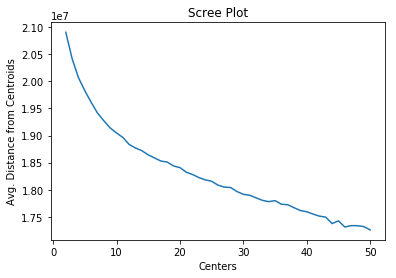

In [82]:
plt.plot(centers_sample,scores_sample)
plt.title('Scree Plot');
plt.xlabel('Centers');
plt.ylabel('Avg. Distance from Centroids');

a closer look on the first elbow

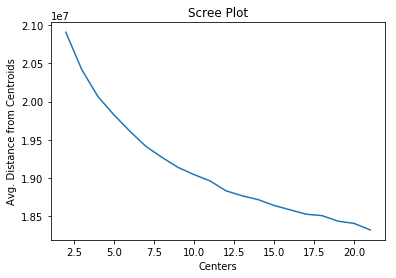

In [83]:
plt.plot(centers_sample[:20],scores_sample[:20]);
plt.title('Scree Plot');
plt.xlabel('Centers');
plt.ylabel('Avg. Distance from Centroids');

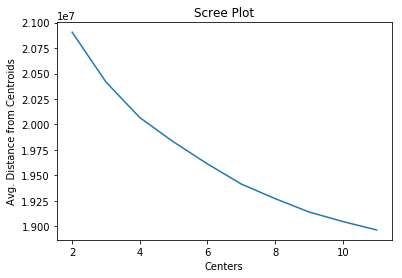

In [84]:
plt.plot(centers_sample[:10],scores_sample[:10]);
plt.title('Scree Plot');
plt.xlabel('Centers');
plt.ylabel('Avg. Distance from Centroids');

In [80]:
try:
    stored = pickle.load(open('kmeans-70.pickle', 'rb'))
    scores = stored['scores']
    times = stored['times']
    centers = stored['centers']
    for k,t in zip(centers, times):
        print(k, t)
except (OSError, IOError) as e:
    scores = []
    times = []
    centers = range(10,71,10)
    for k in centers:
        start = time.time()
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X_pca)
        scores.append(abs(kmeans.score(X_pca)))
        timing = time.time() - start
        print(k,timing)
        times.append(timing)
    stored = {'scores':scores,
              'times':times,
              'centers':centers
             }
    pickle.dump(stored, open('kmeans-70.pickle', 'wb'))

10 382.6422564983368
20 987.9127683639526
30 1103.44100356102
40 1373.474796295166
50 1783.3781361579895
60 2006.7960333824158
70 2219.400752067566


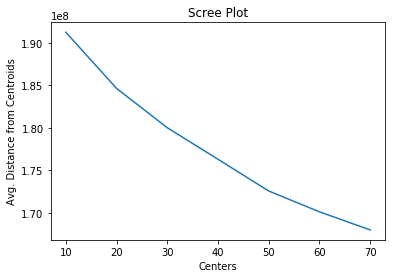

In [85]:
plt.plot(centers,scores);
plt.title('Scree Plot');
plt.xlabel('Centers');
plt.ylabel('Avg. Distance from Centroids');

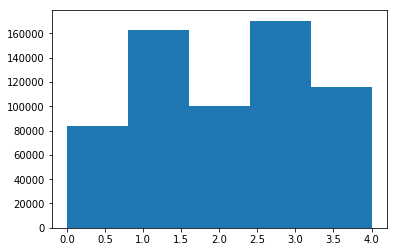

In [86]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca)
labels = kmeans.predict(X_pca)
plt.hist(labels,bins=5);

In [87]:
customers.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=369)

In [89]:
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [90]:
set(azdias.columns) - set(customers.columns)

set()

In [91]:
len(set(azdias.columns) & set(customers.columns))

366

In [133]:
'LNR' in clean_data_by_dropping_cols_with_many_nans(clean_data_replace_missing_values_with_nans(clean_data_by_dropping_type_II(customers.copy())))

Starting Dropping Type II...Completed
Starting Dropping Columns with Many NaNs...Completed


False

In [159]:
customers_clean = clean_data(customers)

Starting Dropping Type II...Completed
Starting Dropping Columns with Many NaNs...Completed
Starting fixing string columns...Completed
Starting processing mixed columns...Completed
Starting processing categorical columns...Completed
Starting Dropping rows with NaNs...Completed
 ZABEOTYP_6.0                                                                      
Conversion to floats Completed


In [93]:
customers_clean.shape

(116993, 360)

Looks like there is a mismatch in the number of columns between the clean customers data and the clean AZDIAS data. This is natural due to the extra 3 columns found in the customers data 
* CUSTOMER_GROUP
* ONLINE_PURCHASE
* PRODUCT_GROUP
Another reason is the categorical columns are split into dummies based on the values in the columns. However, to continue with the same transformations (scaling, pca, kmeans), the number of columns need to match. For that, the missing columns are going to be added as zeros.

In [160]:
set(df.columns) - set(customers_clean.columns)

{'GEBAEUDETYP_5.0'}

In [161]:
set(customers_clean.columns) - set(df.columns)

set()

Looks like `GEBAEUDETYP_5.0` is the only missing column

In [163]:
for col in list(set(df.columns) - set(customers_clean.columns)):
    customers_clean[col] = 0.0 # Just GEBAEUDETYP_5.0 for now

In [164]:
customers_scaled_data = scaler.transform(customers_clean)
customers_scaled_data = pd.DataFrame(customers_scaled_data, columns=customers_clean.columns)
customers_pca = pca.transform(customers_scaled_data)
customers_labels = kmeans.predict(customers_pca)

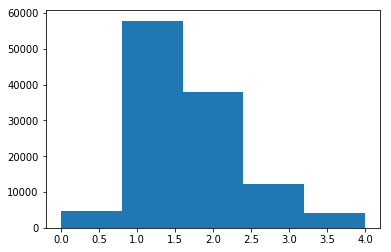

In [165]:
plt.hist(customers_labels,bins=5);

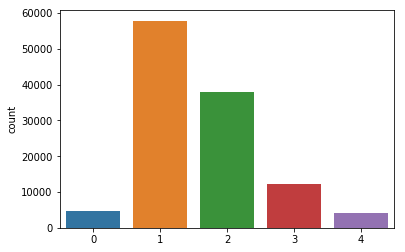

In [166]:
sns.countplot(customers_labels);

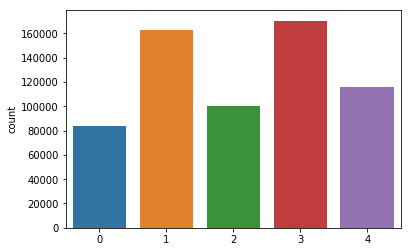

In [167]:
sns.countplot(labels);

In [172]:
def get_related_columns(class_index,head_len=5):
    related_class = kmeans.cluster_centers_[class_index]
    inv_pca_related = pca.inverse_transform(related_class)
    class_related_weights = pd.DataFrame(inv_pca_related.T,
                                         index=df.columns,
                                         columns=range(1))
    return class_related_weights[0][class_related_weights[0]
                                    .abs()
                                    .sort_values(ascending=False).index].head(head_len) 

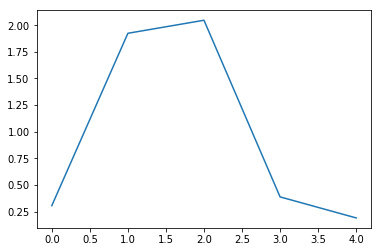

In [176]:
hst,_ = np.histogram(labels,bins=5)
customers_hst,_ = np.histogram(customers_labels, bins=5)
hst_avg, customers_hst_avg = hst/hst.sum(), customers_hst/customers_hst.sum()
ratio = customers_hst_avg/hst_avg
plt.plot(ratio);

In [179]:
overrep = np.argwhere(ratio>1.01)
overrep

array([[1],
       [2]], dtype=int64)

In [180]:
underrep = np.argwhere(ratio<0.99)
underrep

array([[0],
       [3],
       [4]], dtype=int64)

In [181]:
get_related_columns(overrep[0][0])

FINANZ_MINIMALIST    0.865947
MOBI_REGIO           0.747238
KBA05_ANTG1          0.729495
PLZ8_ANTG3          -0.718103
PLZ8_ANTG1           0.716753
Name: 0, dtype: float64

In [182]:
get_related_columns(overrep[1][0])

KBA13_HERST_BMW_BENZ    1.039486
KBA13_SEG_SPORTWAGEN    0.954474
KBA13_KMH_211           0.912223
KBA13_KW_121            0.909522
KBA05_KW3               0.905816
Name: 0, dtype: float64

In [183]:
get_related_columns(underrep[0][0])

OST_WEST_KZ_1.0        -1.822350
KBA13_SITZE_5           1.584630
KBA13_SITZE_4          -1.493858
KBA13_HERST_BMW_BENZ   -1.423412
KBA13_MERCEDES         -1.370618
Name: 0, dtype: float64

In [184]:
get_related_columns(underrep[1][0])

MOBI_REGIO       -0.936821
PLZ8_ANTG3        0.855620
KBA05_GBZ        -0.848131
PLZ8_ANTG1       -0.846721
KBA05_AUTOQUOT   -0.844213
Name: 0, dtype: float64

In [185]:
get_related_columns(underrep[2][0])

FINANZ_UNAUFFAELLIGER               1.062470
PRAEGENDE_JUGENDJAHRE_GENERATION    0.970215
FINANZ_SPARER                       0.948600
SEMIO_PFLICHT                       0.903659
FINANZ_VORSORGER                   -0.901972
Name: 0, dtype: float64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')